In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
nltk.download() #punkt stopwords

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> punkt


      Unzipping tokenizers/punkt.zip.



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> stopwords


      Unzipping corpora/stopwords.zip.



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

## Installations and imports

In [ ]:
# Install Pytorch & other libraries
!pip install "torch==2.1.2" tensorboard

# Install Hugging Face libraries
!pip install  --upgrade \
  "transformers==4.36.2" \
  "datasets==2.16.1" \
  "accelerate==0.26.1" \
  "evaluate==0.4.1" \
  "bitsandbytes==0.42.0" \
  # "trl==0.7.10" # \
  # "peft==0.7.1" \

# install peft & trl from github
!pip install git+https://github.com/huggingface/trl@a3c5b7178ac4f65569975efadc97db2f3749c65e --upgrade
!pip install git+https://github.com/huggingface/peft@4a1559582281fc3c9283892caea8ccef1d6f5a4f --upgrade


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_nvjitlink_cu12-12.6.20-py3-none-manyl

In [ ]:
# import the required libraries
import os
import torch
import string
import pandas as pd
import numpy as np
from pprint import pprint
from random import randrange
from functools import partial
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import re

from nltk.corpus import stopwords
stop_words = set(stopwords.words('turkish'))

from torch.utils.data import DataLoader
import datasets # !pip install datasets
from datasets import load_dataset, Dataset

from transformers import AutoConfig
from peft import LoraConfig, PeftModel, TaskType

# tokenizers
from nltk.tokenize import word_tokenize
from transformers import (
                          GPTJForSequenceClassification,
                          AutoModelForSequenceClassification,
                          AutoTokenizer,
                          Trainer,
                          AutoModelForCausalLM,
                          BitsAndBytesConfig,
                          DataCollatorForLanguageModeling,
                          EarlyStoppingCallback,
                          TrainingArguments,
                          HfArgumentParser,
                          pipeline,
                          logging,
                          set_seed
                          )

import bitsandbytes as bnb
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel, AutoPeftModelForCausalLM
from trl import SFTTrainer
from trl import setup_chat_format

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             classification_report,
                             confusion_matrix)

import evaluate
from evaluate import load


In [ ]:
df_tr_gr_train = pd.read_csv("/content/drive/MyDrive/llm_denemeler/Subtask_A/tr_gr_train.csv")
df_refugee_train = pd.read_csv("/content/drive/MyDrive/llm_denemeler/Subtask_A/refugee_train.csv")
df_isr_pal_train = pd.read_csv("/content/drive/MyDrive/llm_denemeler/Subtask_A/isr_pal_train.csv")

In [ ]:
df_train = pd.concat([df_tr_gr_train, df_isr_pal_train, df_refugee_train], ignore_index=True)
df_train.head()

,id,text,label
0,1568524118357864451,Yunan ülkemizi işgal etmiş namusumuza tecavüz ...,1
1,1527761356061134851,@FeramuzKartal @Neslihan662 Düşüncen dogru kon...,0
2,1503008593372749826,@UfukUras Adaların silahlandırılması savaş seb...,0
3,1568255642095296513,@___MuraT_ASM___ İzmire gavur diyen keske yuna...,1
4,1525787544083910656,Bugünden 103 yıl önce İzmir’de Yunan işgal bir...,0


In [ ]:
print(df_train["text"].iloc[0], df_train["label"].iloc[0], "\n")
print(df_train["text"].iloc[1000], df_train["label"].iloc[1000], "\n")
print(df_train["text"].iloc[2000], df_train["label"].iloc[2000], "\n")
print(df_train["text"].iloc[3000], df_train["label"].iloc[3000] , "\n")
print(df_train["text"].iloc[4000], df_train["label"].iloc[4000], "\n")

Yunan ülkemizi işgal etmiş namusumuza tecavüz ediyor niçin onların ağzına sictik denize döktük demiyorsunuz Osmanlıyı kotuluyorsunuz.Dörtyüz sene çok mu gücünüze gitti.Hala acıyormu. 1 

@hurmafidesi #KuduesBizimdir 
#KudusBizimdir 0 

Mescidi aksâ yanarken arkada zafer kutlaması yapan yahudiler...
ALLAH(c.c)'ın lâneti üzerinize olsun..
#Kahrolsunİsrail 
#israilteroerdevletidir 
#MescidiAksaOnurumuzdur https://t.co/4epq5GIBaM 1 

@username @username Sözcü gazetesi okuyanlar da  vatansever ; kendi vatanlarını seviyorlar ABD iTrail Ermenistan rumkesimi Yunanistan 1 

@@user hocam ülkenin huzuru kalmadı bu şekilde giderse 20 30 seneye türk ırkı kendi vatanında sığınmacı durumuna düşecektir.. misafirlik bir yere kadardır misafirin kısa kalanı makbuldür 0 



In [ ]:
# emojiler
print(df_train["text"].iloc[1200], df_train["label"].iloc[1200] , "\n")

#kürecik açıkken kahrolsun israil naraları 😁
#FilistinKazanıyor neyi?
#FilistinDireniyor kime?
#KüreciğiKapat yoo? 0 



## Process The Data

**Extending the stopwords**

In [ ]:
stop_words = stop_words.union(["bir", "kadar", "sonra", "kere", "mi", "ye", "te", "ta", "nun", "daki", "nın", "ten", "nin", "nün"])
#stop_words

In [ ]:
def remove_punctuation(text):
    return ''.join(d for d in text if d not in string.punctuation or d == '!' or d == '?')

In [ ]:
def remove_extra_space(text):
    text = re.sub(' +', ' ', text)
    return text.strip()

In [ ]:
def remove_emoji(text):
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)
    return text

In [ ]:
# creating a function to process the data
def data_processing(text):

    text = re.sub('\n', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub(r"https\S+|www\S+http\S+", '', text, flags = re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = text.replace('I','ı') # lower() için
    text = text.replace('İ','i')
    text = text.lower()
    text = re.sub(r'\d', '', text)

    text = remove_punctuation(text)
    text = remove_extra_space(text)
    text = remove_emoji(text)

    text_tokens = word_tokenize(text)

    filtered_text = [w for w in text_tokens if not w in stop_words]

    return " ".join(filtered_text)


### Applying the processing algorithm

In [ ]:
df_tr_gr_train.text = df_tr_gr_train['text'].apply(data_processing)
df_tr_gr_train = df_tr_gr_train.drop_duplicates('text')

In [ ]:
df_refugee_train.text = df_refugee_train['text'].apply(data_processing)
df_refugee_train = df_refugee_train.drop_duplicates('text')

In [ ]:
df_isr_pal_train.text = df_isr_pal_train['text'].apply(data_processing)
df_isr_pal_train = df_isr_pal_train.drop_duplicates('text')

In [ ]:
print(df_tr_gr_train["text"].iloc[0], "\n")
print(df_tr_gr_train["text"].iloc[1], "\n")
print(df_tr_gr_train["text"].iloc[2], "\n")
print(df_tr_gr_train["text"].iloc[3], "\n")
print(df_tr_gr_train["text"].iloc[4], "\n")

yunan ülkemizi işgal etmiş namusumuza tecavüz ediyor onların ağzına sictik denize döktük demiyorsunuz osmanlıyı kotuluyorsunuzdörtyüz sene gücünüze gittihala acıyormu 

feramuzkartal neslihan düşüncen dogru konuya yanlış yerden bakıyorsunrusya ukranya nato üyesi değil yunanistan türkiye savaşı olursa iki ülke nato üyesinasıl olacak ? atina kara sınırını mile çıkartır işte zaman savaş başlar günde teslim alırbuna ülke bile destek vermez 

ufukuras adaların silahlandırılması savaş sebebidir tabi öncelik diplomasidir fakat yunanistan var olan antlaşmayı yok sayıp adaları silahlandırıyordiplomasiden sonuç alınmazsa savaşırsınız durumu kabullenirsiniz 

muratasm izmire gavur diyen keske yunan kazansaydı diyen ermeni tohumlarına birakacaz zannediyorsunuz güzel izmiri bütün hainleri denize yine dökeriz sıkıntı yok yaşa mustafa kemal paşa yaşa 

bugünden yıl önce izmir ’ yunan işgal birliklerine ilk kurşunu atan milli mücadele ’ ateşinı yakan kahraman hasantahsin ‘ i saygı rahmet minnetle anıy

In [ ]:
df_train = pd.concat([df_tr_gr_train, df_refugee_train, df_isr_pal_train], ignore_index=True)
df_train

,id,text,label
0,1568524118357864451,yunan ülkemizi işgal etmiş namusumuza tecavüz ...,1
1,1527761356061134851,feramuzkartal neslihan düşüncen dogru konuya y...,0
2,1503008593372749826,ufukuras adaların silahlandırılması savaş sebe...,0
3,1568255642095296513,muratasm izmire gavur diyen keske yunan kazans...,1
4,1525787544083910656,bugünden yıl önce izmir ’ yunan işgal birlikle...,0
...,...,...,...
8452,1393434648647192577,kudüseyürüyoruz sponsoru şeytan olan katil siy...,1
8453,1515487032570789894,mübarek günlerin hürmetine özgürleştir ilk kıb...,0
8454,1391751856884523008,bugün ibadethaneye saldırılıyor yalnızca ibade...,0
8455,1514963851342663684,kurşun atıyorsunuz işlemiyor ! çocuklarımızı k...,1


In [ ]:
df_train = df_train.drop_duplicates('text')
df_train

,id,text,label
0,1568524118357864451,yunan ülkemizi işgal etmiş namusumuza tecavüz ...,1
1,1527761356061134851,feramuzkartal neslihan düşüncen dogru konuya y...,0
2,1503008593372749826,ufukuras adaların silahlandırılması savaş sebe...,0
3,1568255642095296513,muratasm izmire gavur diyen keske yunan kazans...,1
4,1525787544083910656,bugünden yıl önce izmir ’ yunan işgal birlikle...,0
...,...,...,...
8452,1393434648647192577,kudüseyürüyoruz sponsoru şeytan olan katil siy...,1
8453,1515487032570789894,mübarek günlerin hürmetine özgürleştir ilk kıb...,0
8454,1391751856884523008,bugün ibadethaneye saldırılıyor yalnızca ibade...,0
8455,1514963851342663684,kurşun atıyorsunuz işlemiyor ! çocuklarımızı k...,1


In [ ]:
df_test = pd.concat([df_tr_gr_train, df_refugee_train, df_isr_pal_train], ignore_index=True)
df_test = df_test.drop_duplicates('text')
df_test

,id,text,label
0,1568524118357864451,yunan ülkemizi işgal etmiş namusumuza tecavüz ...,1
1,1527761356061134851,feramuzkartal neslihan düşüncen dogru konuya y...,0
2,1503008593372749826,ufukuras adaların silahlandırılması savaş sebe...,0
3,1568255642095296513,muratasm izmire gavur diyen keske yunan kazans...,1
4,1525787544083910656,bugünden yıl önce izmir ’ yunan işgal birlikle...,0
...,...,...,...
8452,1393434648647192577,kudüseyürüyoruz sponsoru şeytan olan katil siy...,1
8453,1515487032570789894,mübarek günlerin hürmetine özgürleştir ilk kıb...,0
8454,1391751856884523008,bugün ibadethaneye saldırılıyor yalnızca ibade...,0
8455,1514963851342663684,kurşun atıyorsunuz işlemiyor ! çocuklarımızı k...,1


**Formating the data**

In [ ]:
def formatting(data):
    data.insert(0, "instruction", "Metni negatif veya pozitif olarak sınıflandır.")
    data.drop('id', inplace=True, axis=1)
    data["label"] = data["label"].apply(lambda x: "negatif" if x==1 else "pozitif")
    data.rename(columns={"text": "input"}, inplace=True)

    return data

In [ ]:
df_train

,id,text,label
0,1568524118357864451,yunan ülkemizi işgal etmiş namusumuza tecavüz ...,1
1,1527761356061134851,feramuzkartal neslihan düşüncen dogru konuya y...,0
2,1503008593372749826,ufukuras adaların silahlandırılması savaş sebe...,0
3,1568255642095296513,muratasm izmire gavur diyen keske yunan kazans...,1
4,1525787544083910656,bugünden yıl önce izmir ’ yunan işgal birlikle...,0
...,...,...,...
8452,1393434648647192577,kudüseyürüyoruz sponsoru şeytan olan katil siy...,1
8453,1515487032570789894,mübarek günlerin hürmetine özgürleştir ilk kıb...,0
8454,1391751856884523008,bugün ibadethaneye saldırılıyor yalnızca ibade...,0
8455,1514963851342663684,kurşun atıyorsunuz işlemiyor ! çocuklarımızı k...,1


In [ ]:
df_train = formatting(df_train)
df_train

<ipython-input-21-28d35b452c16>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('id', inplace=True, axis=1)
<ipython-input-21-28d35b452c16>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["label"] = data["label"].apply(lambda x: "negatif" if x==1 else "pozitif")
<ipython-input-21-28d35b452c16>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={

,instruction,input,label
0,Metni negatif veya pozitif olarak sınıflandır.,yunan ülkemizi işgal etmiş namusumuza tecavüz ...,negatif
1,Metni negatif veya pozitif olarak sınıflandır.,feramuzkartal neslihan düşüncen dogru konuya y...,pozitif
2,Metni negatif veya pozitif olarak sınıflandır.,ufukuras adaların silahlandırılması savaş sebe...,pozitif
3,Metni negatif veya pozitif olarak sınıflandır.,muratasm izmire gavur diyen keske yunan kazans...,negatif
4,Metni negatif veya pozitif olarak sınıflandır.,bugünden yıl önce izmir ’ yunan işgal birlikle...,pozitif
...,...,...,...
8452,Metni negatif veya pozitif olarak sınıflandır.,kudüseyürüyoruz sponsoru şeytan olan katil siy...,negatif
8453,Metni negatif veya pozitif olarak sınıflandır.,mübarek günlerin hürmetine özgürleştir ilk kıb...,pozitif
8454,Metni negatif veya pozitif olarak sınıflandır.,bugün ibadethaneye saldırılıyor yalnızca ibade...,pozitif
8455,Metni negatif veya pozitif olarak sınıflandır.,kurşun atıyorsunuz işlemiyor ! çocuklarımızı k...,negatif


### Creating Bitsandbytes Configuration

In [ ]:
def create_bnb_config(load_in_4bit, bnb_4bit_use_double_quant, bnb_4bit_quant_type, bnb_4bit_compute_dtype):
    """
    Configures model quantization method using bitsandbytes to speed up training and inference

    :param load_in_4bit: Load model in 4-bit precision mode
    :param bnb_4bit_use_double_quant: Nested quantization for 4-bit model
    :param bnb_4bit_quant_type: Quantization data type for 4-bit model
    :param bnb_4bit_compute_dtype: Computation data type for 4-bit model
    """

    bnb_config = BitsAndBytesConfig(
        load_in_4bit = load_in_4bit,
        bnb_4bit_use_double_quant = bnb_4bit_use_double_quant,
        bnb_4bit_quant_type = bnb_4bit_quant_type,
        bnb_4bit_compute_dtype = bnb_4bit_compute_dtype,
    )

    return bnb_config

## Loading Hugging Face Model and Tokenizer

In [ ]:
def load_model(model_name, bnb_config):
    """
    Loads model and model tokenizer

    :param model_name: Hugging Face model name
    :param bnb_config: Bitsandbytes configuration
    """

    # Get number of GPU device and set maximum memory
    n_gpus = torch.cuda.device_count()
    max_memory = f'{40960}MB'

    # Load model
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config = bnb_config,
        device_map = "auto", # dispatch the model efficiently on the available resources
        torch_dtype=torch.bfloat16,
        max_memory = {i: max_memory for i in range(n_gpus)},
    )

    # Load model tokenizer with the user authentication token
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Set padding token as EOS token
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    return model, tokenizer

In [ ]:
################################################################################
# transformers parameters
################################################################################

# The pre-trained model from the Hugging Face Hub to load and fine-tune
model_name = "Trendyol/Trendyol-LLM-7b-chat-dpo-v1.0"

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
load_in_4bit = True

# Activate nested quantization for 4-bit base models (double quantization)
bnb_4bit_use_double_quant = True

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Compute data type for 4-bit base models
bnb_4bit_compute_dtype = torch.bfloat16

In [ ]:
# Load model from Hugging Face Hub with model name and bitsandbytes configuration

bnb_config = create_bnb_config(load_in_4bit, bnb_4bit_use_double_quant, bnb_4bit_quant_type, bnb_4bit_compute_dtype)

model, tokenizer = load_model(model_name, bnb_config)

model, tokenizer = setup_chat_format(model, tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.84G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

In [ ]:
model

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(44314, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
   

### Dataset



In [ ]:
df_train.to_csv('hate_classification.csv', index=False)

In [ ]:
dataset_name = "/content/hate_classification.csv"

In [ ]:
dataset = load_dataset("csv", data_files = dataset_name, split = "train").shuffle().select(range(1000))
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['instruction', 'input', 'label'],
    num_rows: 1000
})

In [ ]:
dataset

Dataset({
    features: ['instruction', 'input', 'label'],
    num_rows: 1000
})

In [ ]:
dataset = dataset.train_test_split(test_size=500/1000)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'label'],
        num_rows: 500
    })
    test: Dataset({
        features: ['instruction', 'input', 'label'],
        num_rows: 500
    })
})

In [ ]:
print(f'Number of prompts: {len(dataset)}')
print(f'Column names are: {dataset.column_names}')

Number of prompts: 2
Column names are: {'train': ['instruction', 'input', 'label'], 'test': ['instruction', 'input', 'label']}


In [ ]:
dataset["train"][randrange(len(dataset))]

{'instruction': 'Metni negatif veya pozitif olarak sınıflandır.',
 'input': 'kendi ülkemde endişe içinde yaşiyorum ülkemde afgan suriyeli istemiyorum can güvenliğimiz yok baksan yanbaktın öldürüyolar artık yeter birileri durdesin ülkemizimi terkedelim',
 'label': 'pozitif'}

In [ ]:
dataset["train"][5]

{'instruction': 'Metni negatif veya pozitif olarak sınıflandır.',
 'input': 'sadece yıkılan binalar uğraşmıyoruz sadece vefat edenlere üzülmüyoruz yıkılan ahlak yıkılan vicdan hala yaşayan insan artıklarına üzülüyoruz utanıyorum sizin adınıza yağmacılar abiyegönderenler',
 'label': 'negatif'}

In [ ]:
train = dataset["train"]
train

Dataset({
    features: ['instruction', 'input', 'label'],
    num_rows: 500
})

In [ ]:
test = dataset["test"]
test

Dataset({
    features: ['instruction', 'input', 'label'],
    num_rows: 500
})

### Creating Prompt Template

In [ ]:
def create_prompt_formats(sample):
    """
    Creates a formatted prompt template for a prompt in the instruction dataset

    :param sample: Prompt or sample from the instruction dataset
    """

    # Initialize static strings for the prompt template
    INTRO_BLURB = "[INST] Aşağıda bir görevi açıklayan bir talimat bulunmaktadır. Talimatı uygun şekilde tamamlayan bir yanıt yazın."
    INSTRUCTION_KEY = "Talimat:"
    INPUT_KEY = "Metin:"
    RESPONSE_KEY = "Yanıt:"
    END_KEY = "[/INST]"

    # Combine a prompt with the static strings
    blurb = f"{INTRO_BLURB}"
    instruction = f"{INSTRUCTION_KEY}\n{sample['instruction']}"
    input_context = f"{INPUT_KEY}\n{sample['input']}" if sample["input"] else None
    response = f"{RESPONSE_KEY}{sample['label']}"
    end = f"{END_KEY}"

    # Create a list of prompt template elements
    parts = [part for part in [blurb, instruction, input_context, response, end] if part]

    # Join prompt template elements into a single string to create the prompt template
    formatted_prompt = "\n\n".join(parts)

    # Store the formatted prompt template in a new key "text"
    sample["text"] = formatted_prompt

    return sample

In [ ]:
def create_prompt_test_formats(sample):
    """
    Creates a formatted prompt template for a prompt in the instruction dataset

    :param sample: Prompt or sample from the instruction dataset
    """

    # Initialize static strings for the prompt template
    INTRO_BLURB = "[INST] Aşağıda bir görevi açıklayan bir talimat bulunmaktadır. Talimatı uygun şekilde tamamlayan bir yanıt yazın."
    INSTRUCTION_KEY = "Talimat:"
    INPUT_KEY = "Metin:"
    RESPONSE_KEY = "Yanıt:"

    # Combine a prompt with the static strings
    blurb = f"{INTRO_BLURB}"
    instruction = f"{INSTRUCTION_KEY}\n{sample['instruction']}"
    input_context = f"{INPUT_KEY}\n{sample['input']}" if sample["input"] else None
    response = f"{RESPONSE_KEY}"

    # Create a list of prompt template elements
    parts = [part for part in [blurb, instruction, input_context, response] if part]

    # Join prompt template elements into a single string to create the prompt template
    formatted_prompt = "\n\n".join(parts)

    # Store the formatted prompt template in a new key "text"
    sample["text"] = formatted_prompt

    return sample

In [ ]:
create_prompt_formats(train[randrange(len(dataset))])

{'instruction': 'Metni negatif veya pozitif olarak sınıflandır.',
 'input': 'kendi ülkemde endişe içinde yaşiyorum ülkemde afgan suriyeli istemiyorum can güvenliğimiz yok baksan yanbaktın öldürüyolar artık yeter birileri durdesin ülkemizimi terkedelim',
 'label': 'pozitif',
 'text': '[INST] Aşağıda bir görevi açıklayan bir talimat bulunmaktadır. Talimatı uygun şekilde tamamlayan bir yanıt yazın.\n\nTalimat:\nMetni negatif veya pozitif olarak sınıflandır.\n\nMetin:\nkendi ülkemde endişe içinde yaşiyorum ülkemde afgan suriyeli istemiyorum can güvenliğimiz yok baksan yanbaktın öldürüyolar artık yeter birileri durdesin ülkemizimi terkedelim\n\nYanıt:pozitif\n\n[/INST]'}

In [ ]:
create_prompt_test_formats(test[randrange(len(dataset))])

{'instruction': 'Metni negatif veya pozitif olarak sınıflandır.',
 'input': 'user milyonluk ülkede milyon test herşey buna göre ölçülmüş suriyeliler kayıp yabamcılar kayıp sayı hangi şehir kaç kişi kayıp evine git kendi karantinananı al söylemenler kayıp şekilde gömüldü kayıp iyi oran',
 'label': 'pozitif',
 'text': '[INST] Aşağıda bir görevi açıklayan bir talimat bulunmaktadır. Talimatı uygun şekilde tamamlayan bir yanıt yazın.\n\nTalimat:\nMetni negatif veya pozitif olarak sınıflandır.\n\nMetin:\nuser milyonluk ülkede milyon test herşey buna göre ölçülmüş suriyeliler kayıp yabamcılar kayıp sayı hangi şehir kaç kişi kayıp evine git kendi karantinananı al söylemenler kayıp şekilde gömüldü kayıp iyi oran\n\nYanıt:'}

### Getting Maximum Sequence Length of the Pre-trained Model

In [ ]:
def get_max_length(model):
    """
    Extracts maximum token length from the model configuration

    :param model: Hugging Face model
    """

    # Pull model configuration
    conf = model.config
    # Initialize a "max_length" variable to store maximum sequence length as null
    max_length = None
    # Find maximum sequence length in the model configuration and save it in "max_length" if found
    for length_setting in ["n_positions", "max_position_embeddings", "seq_length"]:
        max_length = getattr(model.config, length_setting, None)
        if max_length:
            print(f"Found max lenth: {max_length}")
            break
    # Set "max_length" to 1024 (default value) if maximum sequence length is not found in the model configuration
    if not max_length:
        max_length = 1024
        print(f"Using default max length: {max_length}")
    return max_length

### Preprocessing Dataset

In [ ]:
def preprocess_dataset(seed, dataset: str):
    """
    Tokenizes dataset for fine-tuning

    :param tokenizer (AutoTokenizer): Model tokenizer
    :param max_length (int): Maximum number of tokens to emit from the tokenizer
    :param seed: Random seed for reproducibility
    :param dataset (str): Instruction dataset
    """

    # Add prompt to each sample
    print("Preprocessing dataset...")
    dataset = dataset.map(create_prompt_formats)

    # Apply preprocessing to each batch of the dataset & and remove "instruction", "input", "output", and "text" fields

    dataset = dataset.remove_columns(["instruction", "input", "label"])

    # Shuffle dataset
    dataset = dataset.shuffle(seed = seed)

    return dataset

In [ ]:
def preprocess_test_dataset(dataset: str):
    """
    Tokenizes dataset for fine-tuning

    :param tokenizer (AutoTokenizer): Model tokenizer
    :param max_length (int): Maximum number of tokens to emit from the tokenizer
    :param seed: Random seed for reproducibility
    :param dataset (str): Instruction dataset
    """

    # Add prompt to each sample
    print("Preprocessing dataset...")
    dataset = dataset.map(create_prompt_test_formats)

    dataset = dataset.remove_columns(["instruction", "input", "label"])

    return dataset

In [ ]:
# Random seed
seed = 33

max_length = get_max_length(model)
preprocessed_train = preprocess_dataset(seed, train)

Found max lenth: 32768
Preprocessing dataset...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
max_length

32768

In [ ]:
max_length = 128

**Note: 32768 is huge, so due to our hardware limitations, we need to adjust to smaller values. For now, just use 128, which is a much smaller value.**

In [ ]:
print(preprocessed_train)

Dataset({
    features: ['text'],
    num_rows: 500
})


In [ ]:
print(preprocessed_train[0])

{'text': '[INST] Aşağıda bir görevi açıklayan bir talimat bulunmaktadır. Talimatı uygun şekilde tamamlayan bir yanıt yazın.\n\nTalimat:\nMetni negatif veya pozitif olarak sınıflandır.\n\nMetin:\nbana bak afgan mısınız sikimsiniz taliban bayrağını kıvırır götünüze sokarız burası kabil değil ananızı sikeriz sizin orospu çocuğu burası türk yurdu başkent ankara hadi siktir olup gidin şimdi\n\nYanıt:negatif\n\n[/INST]'}


In [ ]:
preprocessed_test = preprocess_test_dataset(test)
preprocessed_test

Preprocessing dataset...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 500
})

In [ ]:
print(preprocessed_test[0])

{'text': '[INST] Aşağıda bir görevi açıklayan bir talimat bulunmaktadır. Talimatı uygun şekilde tamamlayan bir yanıt yazın.\n\nTalimat:\nMetni negatif veya pozitif olarak sınıflandır.\n\nMetin:\nuser milyonluk ülkede milyon test herşey buna göre ölçülmüş suriyeliler kayıp yabamcılar kayıp sayı hangi şehir kaç kişi kayıp evine git kendi karantinananı al söylemenler kayıp şekilde gömüldü kayıp iyi oran\n\nYanıt:'}


### Creating PEFT Configuration

In [ ]:
def create_peft_config(r, lora_alpha, target_modules, lora_dropout, bias, task_type):
    """
    Creates Parameter-Efficient Fine-Tuning configuration for the model

    :param r: LoRA attention dimension
    :param lora_alpha: Alpha parameter for LoRA scaling
    :param modules: Names of the modules to apply LoRA to
    :param lora_dropout: Dropout Probability for LoRA layers
    :param bias: Specifies if the bias parameters should be trained
    """
    config = LoraConfig(
        r = r,
        lora_alpha = lora_alpha,
        target_modules = target_modules,
        lora_dropout = lora_dropout,
        bias = bias,
        task_type = task_type,
    )

    return config

### Finding Modules for LoRA Application

In [ ]:
def find_all_linear_names(model):
    """
    Find modules to apply LoRA to.

    :param model: PEFT model
    """

    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:
        lora_module_names.remove('lm_head')
    print(f"LoRA module names: {list(lora_module_names)}")
    return list(lora_module_names)

In [ ]:
find_all_linear_names(model)

LoRA module names: ['v_proj', 'k_proj', 'o_proj', 'up_proj', 'down_proj', 'gate_proj', 'q_proj']


['v_proj', 'k_proj', 'o_proj', 'up_proj', 'down_proj', 'gate_proj', 'q_proj']

### Calculating Trainable Parameters


In [ ]:
def print_trainable_parameters(model, use_4bit = False):
    """
    Prints the number of trainable parameters in the model.

    :param model: PEFT model
    """

    trainable_params = 0
    all_param = 0

    for _, param in model.named_parameters():
        num_params = param.numel()
        if num_params == 0 and hasattr(param, "ds_numel"):
            num_params = param.ds_numel
        all_param += num_params
        if param.requires_grad:
            trainable_params += num_params

    if use_4bit:
        trainable_params /= 2

    print(
        f"All Parameters: {all_param:,d} || Trainable Parameters: {trainable_params:,d} || Trainable Parameters %: {100 * trainable_params / all_param}"
    )

### Fine-tuning the Pre-trained Model


In [ ]:
output_dir="trained_weigths2"

In [ ]:
args = TrainingArguments(
    output_dir=output_dir,                 # directory to save and repository id
    per_device_train_batch_size=4,          # batch size per device during training
    gradient_accumulation_steps=4,          # number of steps before performing a backward/update pass
    gradient_checkpointing=True,            # use gradient checkpointing to save memory
    learning_rate=5e-4,                     # learning rate, based on QLoRA paper
    optim="paged_adamw_32bit",              # use paged adamw optimizer
    logging_steps=10,                       # log every 10 steps
    max_steps = 50,                         # Number of training steps (overrides num_train_epochs)
    warmup_steps = 2,                       # Linear warmup steps from 0 to learning_rate
    fp16=True,
    bf16=False,
    #fp16 = False,                           # Enable fp16/bf16 training (set bf16 to True with an A100) # When you set True there'll be an error
    max_grad_norm=0.3,                      # max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                      # warmup ratio based on QLoRA paper
    group_by_length=True,
    lr_scheduler_type="cosine",               # use cosine learning rate scheduler
)

In [ ]:
################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 16

# Alpha parameter for LoRA scaling
lora_alpha = 128

# Dropout probability for LoRA layers
lora_dropout = 0.1

# Bias
bias = "none"

# Task type
task_type = "CAUSAL_LM"

In [ ]:
def fine_tune(model,
          tokenizer,
          dataset,
          lora_r,
          lora_alpha,
          lora_dropout,
          bias,
          task_type,
          args):
    """
    Prepares and fine-tune the pre-trained model.

    :param model: Pre-trained Hugging Face model
    :param tokenizer: Model tokenizer
    :param dataset: Preprocessed training dataset
    """

    # Get LoRA module names
    target_modules = find_all_linear_names(model)

    # Create PEFT configuration for these modules and wrap the model to PEFT
    peft_config = create_peft_config(lora_r, lora_alpha, target_modules, lora_dropout, bias, task_type)

    # Print information about the percentage of trainable parameters
    print_trainable_parameters(model)

    trainer = SFTTrainer(
        model=model,
        args=args,
        train_dataset=dataset,
        dataset_text_field="text",
        peft_config=peft_config,
        tokenizer=tokenizer,
        max_seq_length=max_length,
        packing=True,
        dataset_kwargs={
            "add_special_tokens": False,
            "append_concat_token": False,
        }
    )

    do_train = True

    # Launch training and log metrics
    print("Training...")

    if do_train:
        train_result = trainer.train()
        metrics = train_result.metrics
        trainer.log_metrics("train", metrics)
        trainer.save_metrics("train", metrics)
        trainer.save_state()
        print(metrics)

    # Save model
    print("Saving last checkpoint of the model...")
    os.makedirs(output_dir, exist_ok = True)
    trainer.model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

    # Free memory for merging weights
    del model
    del trainer
    torch.cuda.empty_cache()

In [ ]:
fine_tune(model,
      tokenizer,
      preprocessed_train,
      lora_r,
      lora_alpha,
      lora_dropout,
      bias,
      task_type,
      args)

LoRA module names: ['v_proj', 'k_proj', 'o_proj', 'up_proj', 'down_proj', 'gate_proj', 'q_proj']
All Parameters: 3,852,947,456 || Trainable Parameters: 363,286,528 || Trainable Parameters %: 9.428795283316731


Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:310: UserWarning: You passed `packing=True` to the SFTTrainer, and you are training your model with `max_steps` strategy. The dataset will be iterated until the `max_steps` are reached.
  warnings.warn(
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Training...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
10,3.425600
20,2.646700
30,1.941700
40,1.573000
50,1.517700


***** train metrics *****
  epoch                    =       1.98
  total_flos               =  4116461GF
  train_loss               =     2.2209
  train_runtime            = 0:09:57.31
  train_samples_per_second =      1.339
  train_steps_per_second   =      0.084
{'train_runtime': 597.3105, 'train_samples_per_second': 1.339, 'train_steps_per_second': 0.084, 'total_flos': 4420016626728960.0, 'train_loss': 2.220939807891846, 'epoch': 1.98}
Saving last checkpoint of the model...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:141: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


In [ ]:
import gc
for _ in range(100):
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(output_dir)
trained_model = AutoPeftModelForCausalLM.from_pretrained(
    output_dir,
    device_map="auto",
    quantization_config=bnb_config
)
trained_model = trained_model.merge_and_unload()
trained_model

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:257: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(44314, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
   

### Testing the model without fine-tuning

In [ ]:
pipe = pipeline(task="text-generation",
                model=model,
                tokenizer=tokenizer,
                max_new_tokens = 15,
                temperature = 0.0,
               )

In [ ]:
result = pipe("'Aşağıda bir görevi açıklayan bir talimat bulunmaktadır. Talimatı uygun şekilde tamamlayan bir yanıt yazın.\n\n### Talimat:\nMetni negatif veya pozitif olarak sınıflandır.\n\nGirdi:\nuelkemdemuelteciistemiyorum uelkemdesuriyeliistemiyorum uelkemdesığınmacıistemiyorum ulkemdesurıyelııstemıyorum suriyelilersinirdisiedilsin suriyeliistemiyoruz suriyelilersehirlerdencıkartın yağmacılaravuremri askervepolisevuremri vuremriverilsin vuremriverilsin\n\n### Yanıt:'")

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [ ]:
result

[{'generated_text': "'Aşağıda bir görevi açıklayan bir talimat bulunmaktadır. Talimatı uygun şekilde tamamlayan bir yanıt yazın.\n\n### Talimat:\nMetni negatif veya pozitif olarak sınıflandır.\n\nGirdi:\nuelkemdemuelteciistemiyorum uelkemdesuriyeliistemiyorum uelkemdesığınmacıistemiyorum ulkemdesurıyelııstemıyorum suriyelilersinirdisiedilsin suriyeliistemiyoruz suriyelilersehirlerdencıkartın yağmacılaravuremri askervepolisevuremri vuremriverilsin vuremriverilsin\n\n### Yanıt:'\n\nBu metin negatif bir tutum ve istekleri"}]

In [ ]:
result2 = pipe("Aşağıda bir görevi açıklayan bir talimat bulunmaktadır. Talimatı uygun şekilde tamamlayan bir yanıt yazın.\n\nTalimat:\nMetni negatif veya pozitif olarak sınıflandır.\n\nMetin:\nuser inşallah benim eski komşularım gittiler benim umudum kalmadı artık zor allah hala sağ olup enkazda olanlara sabır versin dışardakilere sabır versin vefat edenlere allah rahmet eylesinbabam c bloktaydı onu hanımını ilk gün suriyeliler çıkarmışlar\n\nYanıt:")

In [ ]:
result2

[{'generated_text': 'Aşağıda bir görevi açıklayan bir talimat bulunmaktadır. Talimatı uygun şekilde tamamlayan bir yanıt yazın.\n\nTalimat:\nMetni negatif veya pozitif olarak sınıflandır.\n\nMetin:\nuser inşallah benim eski komşularım gittiler benim umudum kalmadı artık zor allah hala sağ olup enkazda olanlara sabır versin dışardakilere sabır versin vefat edenlere allah rahmet eylesinbabam c bloktaydı onu hanımını ilk gün suriyeliler çıkarmışlar\n\nYanıt:\nMetin, negatif bir tutum ve üzüntü'}]

In [ ]:
test

Dataset({
    features: ['instruction', 'input', 'label'],
    num_rows: 500
})

In [ ]:
test[0:2]

{'instruction': ['Metni negatif veya pozitif olarak sınıflandır.',
  'Metni negatif veya pozitif olarak sınıflandır.'],
 'input': ['username username username username kadın alaka soysuz yunan artığı ? kadınmısın ? kudurmuş sokak köpeği havlarsın işte böyle bana hoşt yunan it eniği demek düşer kendi başını',
  'keşke aynı kalabalık ay önce yunan abd ordusu ege ’ tam ortasında bulunan izmir açıklarındaki iskiri skiros adası ’ ortak tatbikat gerçekleştirip bunun adınada “ düşman ordusunun işgal ettiği adayı kurtarmak olduğu ” dediğinde olsaydı'],
 'label': ['negatif', 'pozitif']}

In [ ]:
prompt_test_data = create_prompt_test_formats(test[0:2])
prompt_test_data

{'instruction': ['Metni negatif veya pozitif olarak sınıflandır.',
  'Metni negatif veya pozitif olarak sınıflandır.'],
 'input': ['username username username username kadın alaka soysuz yunan artığı ? kadınmısın ? kudurmuş sokak köpeği havlarsın işte böyle bana hoşt yunan it eniği demek düşer kendi başını',
  'keşke aynı kalabalık ay önce yunan abd ordusu ege ’ tam ortasında bulunan izmir açıklarındaki iskiri skiros adası ’ ortak tatbikat gerçekleştirip bunun adınada “ düşman ordusunun işgal ettiği adayı kurtarmak olduğu ” dediğinde olsaydı'],
 'label': ['negatif', 'pozitif'],
 'text': "[INST] Aşağıda bir görevi açıklayan bir talimat bulunmaktadır. Talimatı uygun şekilde tamamlayan bir yanıt yazın.\n\nTalimat:\n['Metni negatif veya pozitif olarak sınıflandır.', 'Metni negatif veya pozitif olarak sınıflandır.']\n\nMetin:\n['username username username username kadın alaka soysuz yunan artığı ? kadınmısın ? kudurmuş sokak köpeği havlarsın işte böyle bana hoşt yunan it eniği demek düşer k

In [ ]:
y_true = test["label"]
y_true

['negatif',
 'pozitif',
 'negatif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'negatif',
 'pozitif',
 'negatif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'negatif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'negatif',
 'pozitif',
 'pozitif',
 'negatif',
 'negatif',
 'pozitif',
 'negatif',
 'pozitif',
 'pozitif',
 'negatif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'negatif',
 'pozitif',
 'pozitif',
 'negatif',
 'pozitif',
 'pozitif',
 'pozitif',
 'negatif',
 'pozitif',
 'pozitif',
 'pozitif',
 'negatif',
 'negatif',
 'negatif',
 'negatif',
 'negatif',
 'pozitif',
 'pozitif',
 'negatif',
 'negatif',
 'pozitif',
 'pozitif',
 'negatif',
 'negatif',
 'negatif',
 'negatif',
 'pozitif',
 'pozitif',
 'negatif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'negatif',
 'pozitif',
 'negatif',
 'ne

In [ ]:
preprocessed_test = preprocess_test_dataset(test)

Preprocessing dataset...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
preprocessed_test

Dataset({
    features: ['text'],
    num_rows: 500
})

In [ ]:
preprocessed_test[22]

{'text': '[INST] Aşağıda bir görevi açıklayan bir talimat bulunmaktadır. Talimatı uygun şekilde tamamlayan bir yanıt yazın.\n\nTalimat:\nMetni negatif veya pozitif olarak sınıflandır.\n\nMetin:\nııllcxlj sqedere un bbcword terrorist israel gazzedekatliamvar\n\nYanıt:'}

In [ ]:
def predict(data, model, tokenizer):
    y_pred = []

    for i in range(len(data)):
        prompt = data[i]["text"]

        pipe = pipeline(task="text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        max_new_tokens = 10,
                        temperature = 0.0,
                       )

        result = pipe(prompt)

        answer = result[0]['generated_text'].split(":")[-1]
        #print(answer)

        if "pozitif" in answer:
            y_pred.append("negatif")   # 0 - negatif
        elif "negatif" in answer:
            y_pred.append("pozitif")   # 1 - pozitif
        else:
            y_pred.append("none")

    return y_pred

In [ ]:
y_pred = predict(preprocessed_test, model, tokenizer)
y_pred

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


['pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'negatif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'none',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'none',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif'

#### Changing all "none" values to "negatif" values

In [ ]:
y_pred.count("none")

4

In [ ]:
y_pred_copy = y_pred.copy()
y_pred_copy = [p.replace("none", "negatif") for p in y_pred_copy]

print(y_pred_copy.count("none"))

0


In [ ]:
test[0:7]["label"]

['negatif', 'pozitif', 'negatif', 'pozitif', 'pozitif', 'pozitif', 'pozitif']

In [ ]:
y_pred[0:7]

['pozitif', 'pozitif', 'pozitif', 'pozitif', 'pozitif', 'pozitif', 'pozitif']

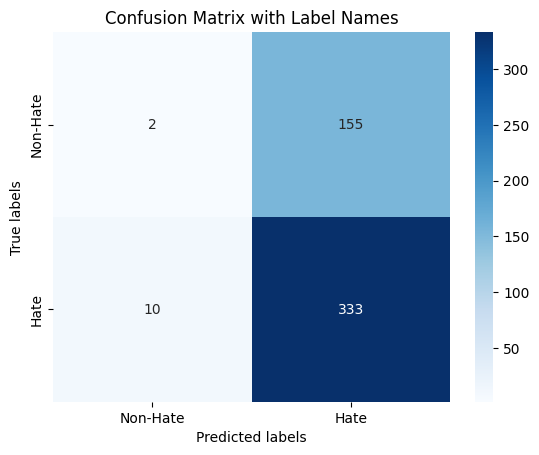

In [ ]:
label_map = {
    'LABEL_0': 'Non-Hate',
    'LABEL_1': 'Hate',
}

cm = confusion_matrix(y_true, y_pred_copy)

# label_map to labels
labels = [label_map[f'LABEL_{i}'] for i in range(len(label_map))]

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix with Label Names')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred_copy))

              precision    recall  f1-score   support

     negatif       0.17      0.01      0.02       157
     pozitif       0.68      0.97      0.80       343

    accuracy                           0.67       500
   macro avg       0.42      0.49      0.41       500
weighted avg       0.52      0.67      0.56       500



In [ ]:
f1_score(y_true, y_pred_copy, average='macro')

0.412556341187277

In [ ]:
f1_score(y_true, y_pred_copy, average='micro')

0.67

In [ ]:
f1_score(y_true, y_pred_copy, average='weighted')

0.5572225663811333

### Testing the model with new prompt (Hate Definition)

**The Definition:** Bu metnin nefret içerikli bir anlamı var mı? Varsa pozitif yoksa negatif şeklinde sınıflandır. Not: Bir metin nefret içeriyorsa veya tehdit, kişisel saldırı, iftira veya istismar gibi metinsel nefret içeriyorsa nefret içerikli olarak sınıflandırılır. Bir metin, olayları bildiriyorsa veya başkalarının görüşlerini nefret içermeyen bir şekilde objektif olarak bildiriyorsa nefret içermeyen olarak kabul edilir.

In [ ]:
test

Dataset({
    features: ['instruction', 'input', 'label'],
    num_rows: 500
})

In [ ]:
test["instruction"][0:5]

['Metni negatif veya pozitif olarak sınıflandır.',
 'Metni negatif veya pozitif olarak sınıflandır.',
 'Metni negatif veya pozitif olarak sınıflandır.',
 'Metni negatif veya pozitif olarak sınıflandır.',
 'Metni negatif veya pozitif olarak sınıflandır.']

In [ ]:
def change_instruction(sample):

    # Initialize static strings for the prompt template
    new = "Bu metnin nefret içerikli bir anlamı var mı? Varsa pozitif yoksa negatif şeklinde sınıflandır. Not: Bir metin nefret içeriyorsa veya tehdit, kişisel saldırı, iftira veya istismar gibi metinsel nefret içeriyorsa nefret içerikli olarak sınıflandırılır. Bir metin, olayları bildiriyorsa veya başkalarının görüşlerini nefret içermeyen bir şekilde objektif olarak bildiriyorsa nefret içermeyen olarak kabul edilir."

    # Store the formatted prompt template in a new key "text"
    sample["instruction"] = new

    return sample

In [ ]:
def preprocess_for_instruction(dataset: str):

    # Add prompt to each sample
    print("Preprocessing dataset...")
    dataset = dataset.map(change_instruction)

    return dataset

In [ ]:
new_test = preprocess_for_instruction(test)

Preprocessing dataset...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
new_test["instruction"][0:5]

['Bu metnin nefret içerikli bir anlamı var mı? Varsa pozitif yoksa negatif şeklinde sınıflandır. Not: Bir metin nefret içeriyorsa veya tehdit, kişisel saldırı, iftira veya istismar gibi metinsel nefret içeriyorsa nefret içerikli olarak sınıflandırılır. Bir metin, olayları bildiriyorsa veya başkalarının görüşlerini nefret içermeyen bir şekilde objektif olarak bildiriyorsa nefret içermeyen olarak kabul edilir.',
 'Bu metnin nefret içerikli bir anlamı var mı? Varsa pozitif yoksa negatif şeklinde sınıflandır. Not: Bir metin nefret içeriyorsa veya tehdit, kişisel saldırı, iftira veya istismar gibi metinsel nefret içeriyorsa nefret içerikli olarak sınıflandırılır. Bir metin, olayları bildiriyorsa veya başkalarının görüşlerini nefret içermeyen bir şekilde objektif olarak bildiriyorsa nefret içermeyen olarak kabul edilir.',
 'Bu metnin nefret içerikli bir anlamı var mı? Varsa pozitif yoksa negatif şeklinde sınıflandır. Not: Bir metin nefret içeriyorsa veya tehdit, kişisel saldırı, iftira veya 

In [ ]:
preprocessed_test = preprocess_test_dataset(new_test)

Preprocessing dataset...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
test[0:2]

{'instruction': ['Metni negatif veya pozitif olarak sınıflandır.',
  'Metni negatif veya pozitif olarak sınıflandır.'],
 'input': ['username username username username kadın alaka soysuz yunan artığı ? kadınmısın ? kudurmuş sokak köpeği havlarsın işte böyle bana hoşt yunan it eniği demek düşer kendi başını',
  'keşke aynı kalabalık ay önce yunan abd ordusu ege ’ tam ortasında bulunan izmir açıklarındaki iskiri skiros adası ’ ortak tatbikat gerçekleştirip bunun adınada “ düşman ordusunun işgal ettiği adayı kurtarmak olduğu ” dediğinde olsaydı'],
 'label': ['negatif', 'pozitif']}

In [ ]:
preprocessed_test[2:5]

{'text': ['[INST] Aşağıda bir görevi açıklayan bir talimat bulunmaktadır. Talimatı uygun şekilde tamamlayan bir yanıt yazın.\n\nTalimat:\nBu metnin nefret içerikli bir anlamı var mı? Varsa pozitif yoksa negatif şeklinde sınıflandır. Not: Bir metin nefret içeriyorsa veya tehdit, kişisel saldırı, iftira veya istismar gibi metinsel nefret içeriyorsa nefret içerikli olarak sınıflandırılır. Bir metin, olayları bildiriyorsa veya başkalarının görüşlerini nefret içermeyen bir şekilde objektif olarak bildiriyorsa nefret içermeyen olarak kabul edilir.\n\nMetin:\nuser uğur kardaş yaa tek hücrelinin ismini öğrenmekle uğraşıcaz hızlı artıyolar \u200d♀️\n\nYanıt:',
  '[INST] Aşağıda bir görevi açıklayan bir talimat bulunmaktadır. Talimatı uygun şekilde tamamlayan bir yanıt yazın.\n\nTalimat:\nBu metnin nefret içerikli bir anlamı var mı? Varsa pozitif yoksa negatif şeklinde sınıflandır. Not: Bir metin nefret içeriyorsa veya tehdit, kişisel saldırı, iftira veya istismar gibi metinsel nefret içeriyorsa

In [ ]:
result3 = pipe("'[INST] Aşağıda bir görevi açıklayan bir talimat bulunmaktadır. Talimatı uygun şekilde tamamlayan bir yanıt yazın.\n\nTalimat:\nBu metnin nefret içerikli bir anlamı var mı? Varsa pozitif yoksa negatif şeklinde sınıflandır. Not: Bir metin nefret içeriyorsa veya tehdit, kişisel saldırı, iftira veya istismar gibi metinsel nefret içeriyorsa nefret içerikli olarak sınıflandırılır. Bir metin, olayları bildiriyorsa veya başkalarının görüşlerini nefret içermeyen bir şekilde objektif olarak bildiriyorsa nefret içermeyen olarak kabul edilir.\n\nMetin:\nusername username username username kadın alaka soysuz yunan artığı ? kadınmısın ? kudurmuş sokak köpeği havlarsın işte böyle bana hoşt yunan it eniği demek düşer kendi başını\n\nYanıt:")

In [ ]:
result3

[{'generated_text': "'[INST] Aşağıda bir görevi açıklayan bir talimat bulunmaktadır. Talimatı uygun şekilde tamamlayan bir yanıt yazın.\n\nTalimat:\nBu metnin nefret içerikli bir anlamı var mı? Varsa pozitif yoksa negatif şeklinde sınıflandır. Not: Bir metin nefret içeriyorsa veya tehdit, kişisel saldırı, iftira veya istismar gibi metinsel nefret içeriyorsa nefret içerikli olarak sınıflandırılır. Bir metin, olayları bildiriyorsa veya başkalarının görüşlerini nefret içermeyen bir şekilde objektif olarak bildiriyorsa nefret içermeyen olarak kabul edilir.\n\nMetin:\nusername username username username kadın alaka soysuz yunan artığı ? kadınmısın ? kudurmuş sokak köpeği havlarsın işte böyle bana hoşt yunan it eniği demek düşer kendi başını\n\nYanıt:\nBu metin nefret içerikli bir anlamı içermektedir. Pozitif yahut negatif"}]

In [ ]:
result4 = pipe('[INST] Aşağıda bir görevi açıklayan bir talimat bulunmaktadır. Talimatı uygun şekilde tamamlayan bir yanıt yazın.\n\nTalimat:\nBu metnin nefret içerikli bir anlamı var mı? Varsa pozitif yoksa negatif şeklinde sınıflandır. Not: Bir metin nefret içeriyorsa veya tehdit, kişisel saldırı, iftira veya istismar gibi metinsel nefret içeriyorsa nefret içerikli olarak sınıflandırılır. Bir metin, olayları bildiriyorsa veya başkalarının görüşlerini nefret içermeyen bir şekilde objektif olarak bildiriyorsa nefret içermeyen olarak kabul edilir.\n\nMetin:\nkeşke aynı kalabalık ay önce yunan abd ordusu ege ’ tam ortasında bulunan izmir açıklarındaki iskiri skiros adası ’ ortak tatbikat gerçekleştirip bunun adınada “ düşman ordusunun işgal ettiği adayı kurtarmak olduğu ” dediğinde olsaydı\n\nYanıt:')

In [ ]:
result4

[{'generated_text': '[INST] Aşağıda bir görevi açıklayan bir talimat bulunmaktadır. Talimatı uygun şekilde tamamlayan bir yanıt yazın.\n\nTalimat:\nBu metnin nefret içerikli bir anlamı var mı? Varsa pozitif yoksa negatif şeklinde sınıflandır. Not: Bir metin nefret içeriyorsa veya tehdit, kişisel saldırı, iftira veya istismar gibi metinsel nefret içeriyorsa nefret içerikli olarak sınıflandırılır. Bir metin, olayları bildiriyorsa veya başkalarının görüşlerini nefret içermeyen bir şekilde objektif olarak bildiriyorsa nefret içermeyen olarak kabul edilir.\n\nMetin:\nkeşke aynı kalabalık ay önce yunan abd ordusu ege ’ tam ortasında bulunan izmir açıklarındaki iskiri skiros adası ’ ortak tatbikat gerçekleştirip bunun adınada “ düşman ordusunun işgal ettiği adayı kurtarmak olduğu ” dediğinde olsaydı\n\nYanıt:\nBu metin nefret içerikli bir anlamı içermemektedir. Metin, bir'}]

In [ ]:
result5 = pipe("'[INST] Aşağıda bir görevi açıklayan bir talimat bulunmaktadır. Talimatı uygun şekilde tamamlayan bir yanıt yazın.\n\nTalimat:\nBu metnin nefret içerikli bir anlamı var mı? Varsa pozitif yoksa negatif şeklinde sınıflandır. Not: Bir metin nefret içeriyorsa veya tehdit, kişisel saldırı, iftira veya istismar gibi metinsel nefret içeriyorsa nefret içerikli olarak sınıflandırılır. Bir metin, olayları bildiriyorsa veya başkalarının görüşlerini nefret içermeyen bir şekilde objektif olarak bildiriyorsa nefret içermeyen olarak kabul edilir.\n\nMetin:\ngözaltına alınan uğur kardaş afgan uyruklu kişinin cesetlerin kolunu keserek altın aldığına ilişkin olaya şahit olmadım ancak şehirde tarz iddialar konuşuluyordu demiş yapmayın\n\nYanıt:'")

In [ ]:
result5

[{'generated_text': "'[INST] Aşağıda bir görevi açıklayan bir talimat bulunmaktadır. Talimatı uygun şekilde tamamlayan bir yanıt yazın.\n\nTalimat:\nBu metnin nefret içerikli bir anlamı var mı? Varsa pozitif yoksa negatif şeklinde sınıflandır. Not: Bir metin nefret içeriyorsa veya tehdit, kişisel saldırı, iftira veya istismar gibi metinsel nefret içeriyorsa nefret içerikli olarak sınıflandırılır. Bir metin, olayları bildiriyorsa veya başkalarının görüşlerini nefret içermeyen bir şekilde objektif olarak bildiriyorsa nefret içermeyen olarak kabul edilir.\n\nMetin:\ngözaltına alınan uğur kardaş afgan uyruklu kişinin cesetlerin kolunu keserek altın aldığına ilişkin olaya şahit olmadım ancak şehirde tarz iddialar konuşuluyordu demiş yapmayın\n\nYanıt:'':\nBu metin nefret içerikli bir anlamı içermemektedir. Metin,"}]

In [ ]:
def new_predict(data, model, tokenizer):
    y_pred = []

    for i in range(len(data)):
        prompt = data[i]["text"]

        pipe = pipeline(task="text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        max_new_tokens = 15,
                        temperature = 0.0,
                       )

        result = pipe(prompt)

        answer = result[0]['generated_text'].split(":")[-1]
        #print(answer)

        if "içermemektedir" in answer:
            y_pred.append("negatif")   # 0 - negatif
        elif "içermektedir" in answer:
            y_pred.append("pozitif")   # 1 - pozitif
        else:
            y_pred.append("none")

    return y_pred

In [ ]:
y_pred = new_predict(preprocessed_test, model, tokenizer)
y_pred

['pozitif',
 'negatif',
 'negatif',
 'negatif',
 'negatif',
 'pozitif',
 'none',
 'negatif',
 'pozitif',
 'pozitif',
 'negatif',
 'negatif',
 'negatif',
 'negatif',
 'pozitif',
 'negatif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'negatif',
 'pozitif',
 'pozitif',
 'negatif',
 'pozitif',
 'negatif',
 'none',
 'negatif',
 'negatif',
 'pozitif',
 'negatif',
 'negatif',
 'negatif',
 'pozitif',
 'negatif',
 'pozitif',
 'pozitif',
 'pozitif',
 'negatif',
 'pozitif',
 'negatif',
 'negatif',
 'pozitif',
 'negatif',
 'pozitif',
 'negatif',
 'pozitif',
 'negatif',
 'pozitif',
 'pozitif',
 'negatif',
 'pozitif',
 'negatif',
 'negatif',
 'negatif',
 'pozitif',
 'negatif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'pozitif',
 'none',
 'pozitif',
 'pozitif',
 'pozitif',
 'negatif',
 'negatif',
 'negatif',
 'negatif',
 'pozitif',
 'negatif',
 'pozitif',
 'pozitif',
 

In [ ]:
y_pred.count("none")

14

In [ ]:
y_pred_copy = y_pred.copy()
y_pred_copy = [p.replace("none", "negatif") for p in y_pred_copy]

print(y_pred_copy.count("none"))

0


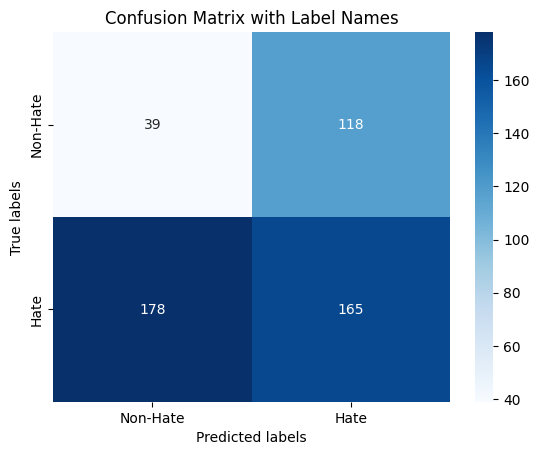

In [ ]:
label_map = {
    'LABEL_0': 'Non-Hate',
    'LABEL_1': 'Hate',
}

cm = confusion_matrix(y_true, y_pred_copy)

# label_map to labels
labels = [label_map[f'LABEL_{i}'] for i in range(len(label_map))]

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix with Label Names')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred_copy))

              precision    recall  f1-score   support

     negatif       0.18      0.25      0.21       157
     pozitif       0.58      0.48      0.53       343

    accuracy                           0.41       500
   macro avg       0.38      0.36      0.37       500
weighted avg       0.46      0.41      0.43       500



In [ ]:
f1_score(y_true, y_pred_copy, average='macro')

0.36785634962669356

In [ ]:
f1_score(y_true, y_pred_copy, average='micro')

0.408

In [ ]:
f1_score(y_true, y_pred_copy, average='weighted')

0.4271160239872888